Based on https://github.com/dfm/george/blob/master/docs/_code/model.py

In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division, print_function

import emcee
#import triangle
import triangle_plot as triangle
import numpy as np
import matplotlib.pyplot as pl

import george
from george import kernels



In [3]:
def model(params, t):
    amp, loc, sig2 = params
    return amp * np.exp(-0.5 * (t - loc) ** 2 / sig2)


def lnprior_base(p):
    amp, loc, sig2 = p
    if not -10 < amp < 10:
        return -np.inf
    if not -5 < loc < 5:
        return -np.inf
    if not 0 < sig2 < 3.0:
        return -np.inf
    return 0.0


def lnlike_ind(p, t, y, invar):
    m = model(p[2:], t) + p[0] * t + p[1]
    return -0.5 * np.sum((y - m) ** 2 * invar)


def lnprior_ind(p):
    m, b = p[:2]
    if not -10 < m < 10:
        return -np.inf
    if not -10 < b < 10:
        return -np.inf
    return lnprior_base(p[2:])


def lnprob_ind(p, t, y, invar):
    lp = lnprior_ind(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_ind(p, t, y, invar)




In [4]:
def fit_ind(initial, data, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_ind, args=data)

    print("Running burn-in")
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)

    return sampler


def lnlike_gp(p, t, y, yerr):
    a, tau = np.exp(p[:2])
    gp = george.GP(a * kernels.Matern32Kernel(tau))
    gp.compute(t, yerr)
    return gp.lnlikelihood(y - model(p[2:], t))


def lnprior_gp(p):
    lna, lntau = p[:2]
    if not -5 < lna < 5:
        return -np.inf
    if not -5 < lntau < 5:
        return -np.inf
    return lnprior_base(p[2:])


def lnprob_gp(p, t, y, yerr):
    lp = lnprior_gp(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_gp(p, t, y, yerr)


def fit_gp(initial, data, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gp, args=data)

    print("Running burn-in")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 5000)

    return sampler


def generate_data(params, N, rng=(-5, 5)):
    gp = george.GP(0.1 * kernels.ExpSquaredKernel(3.3))
    t = rng[0] + np.diff(rng) * np.sort(np.random.rand(N))
    y = gp.sample(t)
    y += model(params, t)
    yerr = 0.05 + 0.05 * np.random.rand(N)
    y += yerr * np.random.randn(N)
    return t, y, yerr



In [6]:
def mymain():
    np.random.seed(1234)
    truth = [-1.0, 0.1, 0.4]
    t, y, yerr = generate_data(truth, 50)
    pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    pl.ylabel(r"$y$")
    pl.xlabel(r"$t$")
    pl.xlim(-5, 5)
    pl.title("simulated data")
    pl.savefig("data.png", dpi=150)

    # Fit assuming independent.
    print("Fitting independent")
    data = (t, y, 1.0 / yerr ** 2)
    truth_ind = [0.0, 0.0] + truth
    sampler = fit_ind(truth_ind, data)

    # Plot the samples in data space.
    print("Making plots")
    samples = sampler.flatchain
    x = np.linspace(-5, 5, 500)
    for s in samples[np.random.randint(len(samples), size=24)]:
        pl.plot(x, model(s[2:], x)+s[0]*x+s[1], color="#4682b4", alpha=0.3)
    pl.title("results assuming uncorrelated noise")
    pl.savefig("ind-results.png")

    # Make the corner plot.
    labels = [r"$\alpha$", r"$\ell$", r"$\sigma^2$"]
    fig = triangle.corner(samples[:, 2:], truths=truth, labels=labels)
    fig.savefig("ind-corner.png")

    # Fit assuming GP.
    print("Fitting GP")
    data = (t, y, yerr)
    truth_gp = [0.0, 0.0] + truth
    sampler = fit_gp(truth_gp, data)

    # Plot the samples in data space.
    print("Making plots")
    samples = sampler.flatchain
    x = np.linspace(-5, 5, 500)
    pl.figure()
    pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    for s in samples[np.random.randint(len(samples), size=24)]:
        gp = george.GP(np.exp(s[0]) * kernels.Matern32Kernel(np.exp(s[1])))
        gp.compute(t, yerr)
        m = gp.sample_conditional(y - model(s[2:], t), x) + model(s[2:], x)
        pl.plot(x, m, color="#4682b4", alpha=0.3)
    pl.ylabel(r"$y$")
    pl.xlabel(r"$t$")
    pl.xlim(-5, 5)
    pl.title("results with Gaussian process noise model")
    pl.savefig("gp-results.png")

    # Make the corner plot.
    fig = triangle.corner(samples[:, 2:], truths=truth, labels=labels)
    fig.savefig("gp-corner.png")

Fitting independent
Running burn-in
Running production
Making plots
Fitting GP
Running burn-in
Running second burn-in
Running production
Making plots


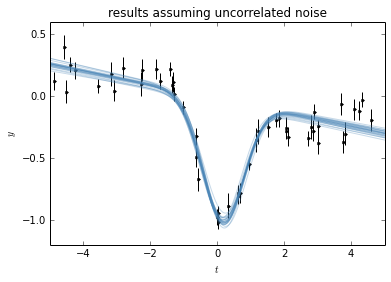

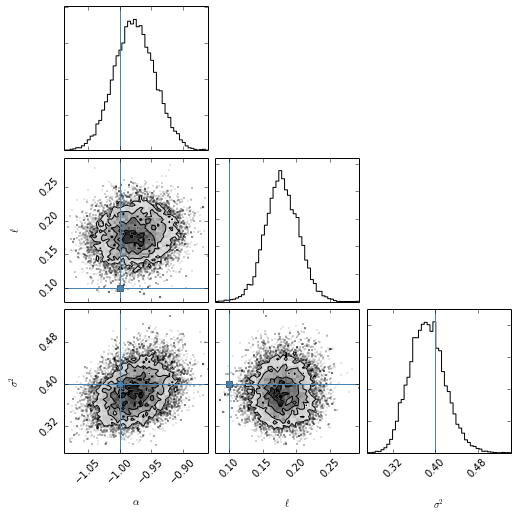

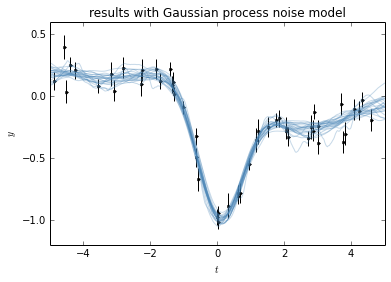

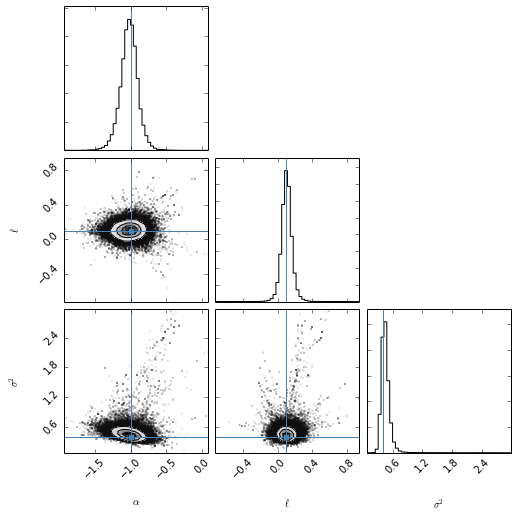

In [7]:
mymain()